In [1]:
import os
import rasterio as rio
import numpy as np
import shapely
import pyproj
import geopandas as gpd
import matplotlib.pyplot as plt
import rioxarray as riox
import rasterio as rio
import xarray as xr
import netCDF4
from osgeo import gdal
import pandas as pd
from datetime import datetime
import dask.array

In [2]:
# define folder and file paths
folder_HMA = os.path.join('C:',os.sep,'Users','lzell','OneDrive - Colostate','Desktop',"HMA2")
folder_glaciers = os.path.join(folder_HMA, 'Glacier Products')
folder_datasets = os.path.join(folder_HMA, 'Datasets')
fp_rgi = os.path.join(folder_HMA, 'Datasets', 'AOI definition', 'Final AOI', "Final Products", 'AOI_full_rgi.shp')
fp_regions = os.path.join(folder_HMA, 'Datasets', 'AOI definition', 'Final AOI', "Final Products", 'subregion_boundaries.shp')

In [3]:
# open the rgi gdf, regions gdf
rgi_gdf = gpd.read_file(fp_rgi).to_crs("ESRI:102025")
regions_gdf = gpd.read_file(fp_regions).to_crs("ESRI:102025")
print(regions_gdf.crs)
print(rgi_gdf.crs)

ESRI:102025
ESRI:102025


In [4]:
# add the o3region as a column to each rgi
regions_gdf = regions_gdf.rename({"id":"o3region"}, axis=1)
rgi_gdf = rgi_gdf.sjoin(regions_gdf[["o3region","geometry"]])

In [5]:
all_regions = np.unique(rgi_gdf['o3region'].values)
c=0
for r in all_regions:
    
    print("Starting region", r)
    
    # subset to the rgi in this region
    gdf_susbet = rgi_gdf[rgi_gdf['o3region']==r]
    
    # define path to the region's water count
    path_open = os.path.join(folder_HMA, "Datasets", "GEE outputs", "water counts",
                             f"water_count_r{str(r).zfill(2)}_accaqa.tif")
    
    # open with riox
    xr_water = riox.open_rasterio(path_open, masked=False,
                                   chunks={"x": 'auto', "y": 'auto'}).astype(float)
    
    # rename bands to the years which they represent
    year_names = [i for i in list(xr_water.long_name)]
    xr_water = xr_water.rename({"band":"year"})
    xr_water['year'] = year_names
    xr_water = xr_water.to_dataset(dim='year')
    
    # define path to the region's usable count
    path_open = os.path.join(folder_HMA, "Datasets", "GEE outputs", "usable counts",
                             f"usable_count_r{str(r).zfill(2)}_accaqa.tif")
    
    # open with riox
    xr_usable = riox.open_rasterio(path_open, masked=True,
                                   chunks={"x": 'auto', "y": 'auto'}).astype(float)
    
    # rename bands to the years which they represent
    year_names = [i for i in list(xr_usable.long_name)]
    xr_usable = xr_usable.rename({"band":"year"})
    xr_usable['year'] = year_names
    xr_usable = xr_usable.to_dataset(dim='year') # to dataset so we save band names
    
    # process each glacier
    for idx, row in gdf_susbet.iterrows():
        c+=1

        # grab glacier geometry, region, rgiid
        rgi_id = row['rgi_id']
        region = row['o3region']
        geom = row['geometry']
        
        # print progress
        # print(r, c, "of", len(rgi_gdf), rgi_id)
        if c%10==1: print(r, c, "of", len(rgi_gdf), rgi_id)
        
        # open glacier mask
        path_mask = os.path.join(folder_glaciers, rgi_id, 'Base Products', 'glacier_mask.tif')
        xr_mask = riox.open_rasterio(path_mask, masked=True).squeeze(drop=True)

        # subset water, usable to the extent of the mask (buffered by a bit)
        xs = [ np.nanmin(xr_mask['x'])-200, np.nanmax(xr_mask['x'])+200 ]
        ys = [ np.nanmin(xr_mask['y'])-200, np.nanmax(xr_mask['y'])+200 ]
        xr_water_subset = xr_water.sel(x=slice(xs[0], xs[1]), y=slice(ys[1], ys[0]))
        xr_usable_subset = xr_usable.sel(x=slice(xs[0], xs[1]), y=slice(ys[1], ys[0]))
        
        
        # clip the water xr to the rgi geometry (buffered by a little bit), fill nan with 0
        xr_water_clipped = xr_water_subset.rio.clip([geom.buffer(200)])
        xr_water_clipped = xr_water_clipped.where(~np.isnan(xr_water_clipped), 0)
        
        # interpolate to the mask grid
        xr_water_interp = xr_water_clipped.interp_like(xr_mask, method='nearest', assume_sorted=False)
        xr_water_interp = xr_water_interp.where(xr_mask>0, np.nan)
        
        
        # clip the water xr to the rgi geometry (buffered by a little bit), fill nan with 0
        xr_usable_clipped = xr_usable_subset.rio.clip([geom.buffer(200)])
        xr_usable_clipped = xr_usable_clipped.where(~np.isnan(xr_usable_clipped), 0)
        
        # interpolate to the mask grid
        xr_usable_interp = xr_usable_clipped.interp_like(xr_mask, method='nearest', assume_sorted=False)
        xr_usable_interp = xr_usable_interp.where(xr_mask>0, np.nan)
        
        
        # we want to combine by every two years between 1988-2003
        # years will be called: 198889, 199091, 199092... 200203, 2004, 2005, etc...
        # year_bins = [[1988,1989],[1990,1991],[1992,1993],[1994,1995],
        #              [1996,1997],[1998,1999],[2000,2001],[2002,2003] ] \
        #             + [[i] for i in range(2004,2024)] 
        year_bins = [[1988,1989,1990,1991],[1992,1993],[1994,1995],
                     [1996,1997],[1998,1999],[2000,2001],[2002,2003] ] \
                    + [[i] for i in range(2004,2024)] 
        
        
        all_ws = []
        all_us = []
        for bin_y in year_bins:
            
            # check which years we have data for
            years_available = [str(y) for y in bin_y if str(y) in year_names]
            
            # treat differently if combining years or using single years
            if len(years_available)==1:
                xr_water_y = xr_water_interp[str(years_available[0])].rename(str(bin_y[0]))
                xr_usable_y = xr_usable_interp[str(years_available[0])].rename(str(bin_y[0]))
                
            elif len(years_available)>=2:
                xr_water_y = xr_water_interp[years_available] \
                                .to_array(dim='year').sum(dim='year').rename(str(bin_y[0]))
                xr_usable_y = xr_usable_interp[years_available] \
                                .to_array(dim='year').sum(dim='year').rename(str(bin_y[0]))
                
            else:
                print("NO DATA",rgi_id,years_available,year_names)
            
            # append to list
            all_ws.append(xr_water_y)
            all_us.append(xr_usable_y)
        
        # recombine into dataset
        xr_usable_interp = xr.merge(all_us)
        xr_water_interp = xr.merge(all_ws)
                
        # we need a different xr_usable_interp product to avoid throwing divide errors when 0
        # these pixels will end up being 0 regardless of what is in denominator, so just set to 1
        usable_divide = xr_usable_interp.where(xr_usable_interp>0, 1)

        # calculate water percent
        xr_percent_water = xr_water_interp/usable_divide
        
        # format off-glacier for all
        xr_usable_interp = xr_usable_interp.where(xr_mask>0, 0).astype(int)
        xr_water_interp = xr_water_interp.where(xr_mask>0, 0).astype(int)
        
        # save as geotiffs
        out_path = os.path.join(folder_glaciers, rgi_id, 'Water', 'glacier_water_count_1318_binned4_accaqa.tif')
        xr_water_interp.rio.to_raster(out_path, compress='LZW', tiled=True)
        
        # save as geotiffs
        # out_path = os.path.join(folder_glaciers, rgi_id, 'Usable', 'glacier_usable_count_binned4_accaqa.tif')
        # xr_usable_interp.rio.to_raster(out_path, compress='LZW', tiled=True)
        
        # save as geotiffs
        out_path = os.path.join(folder_glaciers, rgi_id, 'Water', 'glacier_water_frequency_1318_binned4_accaqa.tif')
        xr_percent_water.rio.to_raster(out_path, compress='LZW', tiled=True)
        
        # break
    # break
print("All done!")

Starting region 1
1 1 of 769 RGI2000-v7.0-G-15-18018
Starting region 2
2 11 of 769 RGI2000-v7.0-G-15-17010
Starting region 3
3 21 of 769 RGI2000-v7.0-G-15-15007
Starting region 4
4 31 of 769 RGI2000-v7.0-G-13-70791
4 41 of 769 RGI2000-v7.0-G-13-71533
4 51 of 769 RGI2000-v7.0-G-13-71730
4 61 of 769 RGI2000-v7.0-G-13-73459
4 71 of 769 RGI2000-v7.0-G-15-11615
Starting region 5
5 81 of 769 RGI2000-v7.0-G-15-11046
Starting region 6
6 91 of 769 RGI2000-v7.0-G-15-09302
6 101 of 769 RGI2000-v7.0-G-15-09687
Starting region 7
7 111 of 769 RGI2000-v7.0-G-15-06437
7 121 of 769 RGI2000-v7.0-G-15-06678
7 131 of 769 RGI2000-v7.0-G-15-06846
7 141 of 769 RGI2000-v7.0-G-15-07196
7 151 of 769 RGI2000-v7.0-G-15-07883
7 161 of 769 RGI2000-v7.0-G-15-08091
7 171 of 769 RGI2000-v7.0-G-15-08438
7 181 of 769 RGI2000-v7.0-G-15-08721
Starting region 8
8 191 of 769 RGI2000-v7.0-G-15-04305
8 201 of 769 RGI2000-v7.0-G-15-04946
8 211 of 769 RGI2000-v7.0-G-15-05074
8 221 of 769 RGI2000-v7.0-G-15-05352
8 231 of 769 RGI

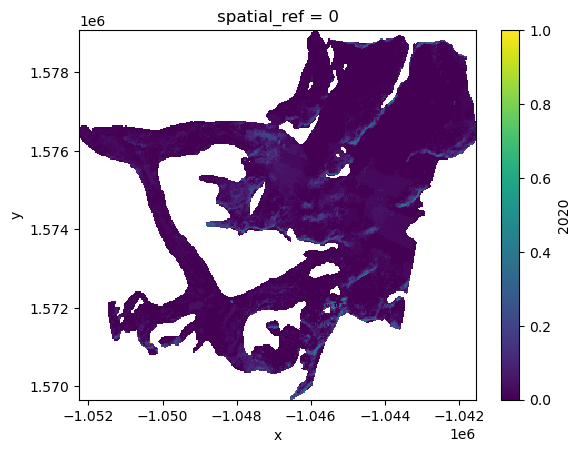

In [6]:
xr_percent_water['2020'].plot()